In [6]:
# %matplotlib widget
# Imports and setup
from pint import UnitRegistry
import math
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import scipy

# Use pint
units = UnitRegistry()
units.default_format = "~P"
ureg = UnitRegistry()
ureg.setup_matplotlib()
Q_ = ureg.Quantity

In [7]:
# Functions Used For Lab
def unpack_oscope(filepath):
    data = pd.read_csv(filepath)
    increment = float(data["Increment"][0])
    data = data.iloc[1: , :]
    data = data.astype(float)
    data["time"] = data["X"] * increment
    return data

def plot_vsh_vdr(voltages):
    start_tick = 0
    end_tick = -1
    
    for voltage in voltages: 
        data = unpack_oscope(f"../data/{voltage}.csv")
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)  
        # Shunt voltage
        ax1.scatter(data["time"][start_tick:end_tick], data["CH1"][start_tick:end_tick], marker='.', s=0.5)
        # Drain Voltage
        ax2.scatter(data["time"][start_tick:end_tick], data["CH2"][start_tick:end_tick], marker='.', s=0.5)

        ax1.sharex(ax2)
        ax1.title.set_text("Shunt Voltage")
        ax2.title.set_text("Drain Voltage")
        ax2.set_xlabel("Time (s)")
        fig.suptitle(f"Shunt and Drain Voltage for V_out = {voltage}V") 

        plt.show()

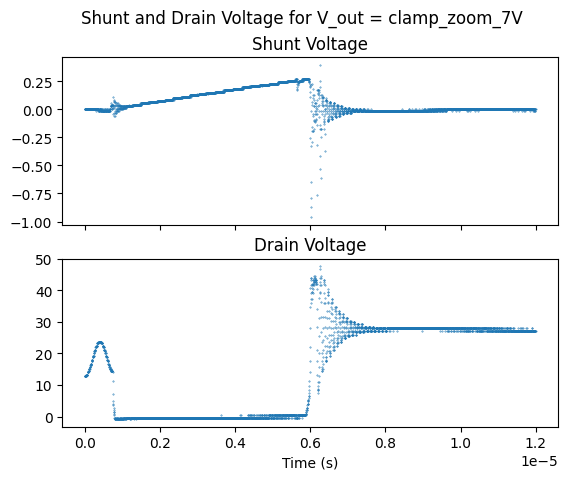

In [16]:
plot_vsh_vdr(["clamp_zoom_7"])